# Table of Contents
* [Loading data](#Loading-data)
	* [ADE](#ADE)
	* [Volume est.](#Volume-est.)
* [Looking at objects](#Looking-at-objects)
* [Looking at scenes](#Looking-at-scenes)
* [Looking at image complexity](#Looking-at-image-complexity)
* [Defining question object categories](#Defining-question-object-categories)
* [Displaying random image and questions](#Displaying-random-image-and-questions)
* [Extacting bounding boxes from segmentation mask](#Extacting-bounding-boxes-from-segmentation-mask)
* [Test Build dataset scaffolding](#Test-Build-dataset-scaffolding)
* [Building selection criteria](#Building-selection-criteria)
* [Build dataset scaffolding](#Build-dataset-scaffolding)
* [Explore synthetic questions](#Explore-synthetic-questions)
	* [observations](#observations)
* [Generate Sample HTML](#Generate-Sample-HTML)
* [hide](#hide)


In [20]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [71]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
# %base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (12.0, 6.0)

In [22]:
import os
import itertools
import random
import cv2
import scipy.io as sio
import PIL.Image as Image

In [120]:
from multiprocessing import Pool
import functools

In [23]:
import pqa_utils.ade_extractor as ade_ext

# Loading data

In [24]:
object_properties = pd.read_csv('../ade20k/object_annotations.csv')

label_assignments = defaultdict(set)
for label_type in object_properties.iloc[:, 1:].columns.tolist():
    label_assignments[label_type].update(object_properties[object_properties[label_type] == 1]['shortname'].tolist())

In [25]:
with open('store_combined_results.pkl', 'rb') as f:
    combined_results = pickle.load(f)

In [261]:
with open('store_indoor_sample_results.pkl', 'rb') as f:
    indoor_sample_images = pickle.load(f)

## ADE

In [35]:
ade_matdata = sio.loadmat('../ade20k/ADE20K_2016_07_26/index_ade20k.mat',  struct_as_record=False, squeeze_me=True)
ade_index = ade_matdata['index']

In [36]:
ade_index._fieldnames

['filename',
 'folder',
 'typeset',
 'objectIsPart',
 'objectPresence',
 'objectcounts',
 'objectnames',
 'proportionClassIsPart',
 'scene',
 'wordnet_found',
 'wordnet_level1',
 'wordnet_synset',
 'wordnet_hypernym',
 'wordnet_gloss',
 'wordnet_synonyms',
 'wordnet_frequency']

In [37]:
image_df = pd.DataFrame([ade_index.filename, ade_index.folder, ade_index.scene]).T
image_df.columns = ['filename', 'folder', 'scene']

In [38]:
obj_df = pd.DataFrame([ade_index.objectnames, ade_index.objectcounts, ade_index.proportionClassIsPart, ade_index.wordnet_found, ade_index.wordnet_level1, 
                       ade_index.wordnet_synset, ade_index.wordnet_hypernym, ade_index.wordnet_gloss, ade_index.wordnet_synonyms, ade_index.wordnet_frequency]).T
obj_df.columns = ['objectnames', 'objectcounts', 'proportionClassIsPart', 'wordnet_found',
 'wordnet_level1',
 'wordnet_synset',
 'wordnet_hypernym',
 'wordnet_gloss',
 'wordnet_synonyms',
 'wordnet_frequency']

img_obj_df = pd.DataFrame(ade_index.objectPresence).T
img_obj_df.index = image_df['filename']
img_obj_df.columns = obj_df['objectnames']

## Volume est.

In [31]:
v_data_train_file = '../volume_est_dataset/data_trainval.txt'

In [32]:
vol_est_df_raw = pd.read_csv(v_data_train_file, sep=' ', header=None)

In [33]:
vol_est_df_raw['rectangle'] = vol_est_df_raw.iloc[:, 2:6].T.apply(lambda x: ' '.join(x.astype(str)))
vol_est_df = pd.concat([vol_est_df_raw.iloc[:, 0:2], vol_est_df_raw.iloc[:, 6:]], axis=1)
vol_est_df.columns = ['image_name', 'obj_name', 'volume', 'vol_bin', 'ns', 'is_occulted', 'rectangle']
vol_est_df['rectangle'] = vol_est_df['rectangle'].apply(lambda x: x.split())

In [34]:
vol_est_df.iloc[:, :-1].apply(lambda x: len(pd.unique(x)))

image_name     5193
obj_name         12
volume          343
vol_bin          11
ns                6
is_occulted       3
dtype: int64

# Looking at objects

In [143]:
# was originally 50
common_objects_df = obj_df[obj_df['objectcounts'] > 10]

In [140]:
common_objects_df['objectnames'].shape

(1034,)

In [41]:
# _ = obj_df[obj_df['wordnet_frequency'] < 6000]['wordnet_frequency'].hist(bins = 60, log=True)

In [144]:
primary_obj_df = common_objects_df[common_objects_df['proportionClassIsPart'] == 0]

In [43]:
primary_obj_df['objectcounts'].sum() / obj_df['objectcounts'].sum()

0.4506219

In [156]:
primary_obj_df.shape

(750, 11)

In [157]:
short_names = {}
for name in primary_obj_df['objectnames']:
    split_names = name.split(',')
    for nc in split_names:
        if nc not in short_names.values():
            short_names[name] = nc.strip()
            break

In [158]:
len(short_names)

750

In [159]:
invert_short_names = {v:k for k,v in short_names.items()}

In [160]:
invert_short_names['tank']

'tank, storage tank'

In [161]:
%%capture
primary_obj_df['shortname'] = primary_obj_df['objectnames'].apply(lambda x: short_names[x])

In [162]:
# object_annotation_blank = pd.DataFrame(np.hstack((primary_obj_df['shortname'].values.reshape(primary_obj_df.shape[0], 1), np.zeros((primary_obj_df.shape[0], 5)))))
# object_annotation_blank.columns = ['shortname', 'metric', 'movable', 'set_on', 'container', 'liquid']

In [163]:
# object_annotation_blank.to_csv('object_annotaions.csv', index=False)

In [53]:
object_properties = pd.read_csv('../ade20k/object_annotations.csv')

# Looking at scenes

In [54]:
coarse_scenes = set([sce.split('/')[0] for sce in ade_index.scene.tolist()])

In [170]:
%page coarse_scenes

In [62]:
indoor_words = ['indoor', 'interior', 'home', 'shop', 'office', 'hall', 'store']
outdoor_words = ['outdoor', 'exterior', 'forest', 'street', 'deck', 'garden', 'house', 'park', 'field', 'arena', 'farm', 'bridge', 'rainforest']

scenes_by_type = defaultdict(set)
for scene in ade_index.scene.tolist():
    if set(indoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])) or 'room' in scene:
        scenes_by_type['indoor'].add(scene)
    elif set(outdoor_words).intersection(set([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])):
        scenes_by_type['outdoor'].add(scene)
    else:
        scenes_by_type['ambiguous'].add(scene)

In [63]:
for k, v in scenes_by_type.items():
    print(k, len(v))

ambiguous 468
indoor 226
outdoor 178


In [64]:
scene_assignments = {}
for stype, scene_cats in scenes_by_type.items():
    for scene_cat in scene_cats:
        scene_assignments[scene_cat] = stype

In [65]:
image_df['setting'] = image_df['scene'].apply(lambda x: scene_assignments[x])

In [66]:
in_out_counts = defaultdict(int)
for scene in ade_index.scene.tolist():
    in_out_counts[scene_assignments[scene]] += 1

In [67]:
in_out_counts

defaultdict(int, {'ambiguous': 10802, 'indoor': 7028, 'outdoor': 4380})

In [68]:
word_pieces = []
for scene in scenes_by_type['ambiguous']:
    word_pieces.extend([item for sublist in [sc.split('_') for sc in scene.split('/')] for item in sublist])

# Looking at image complexity

In [72]:
obj_counts = img_obj_df.sum(axis=1)

In [73]:
winsorized_obj_counts = obj_counts[obj_counts < 200]

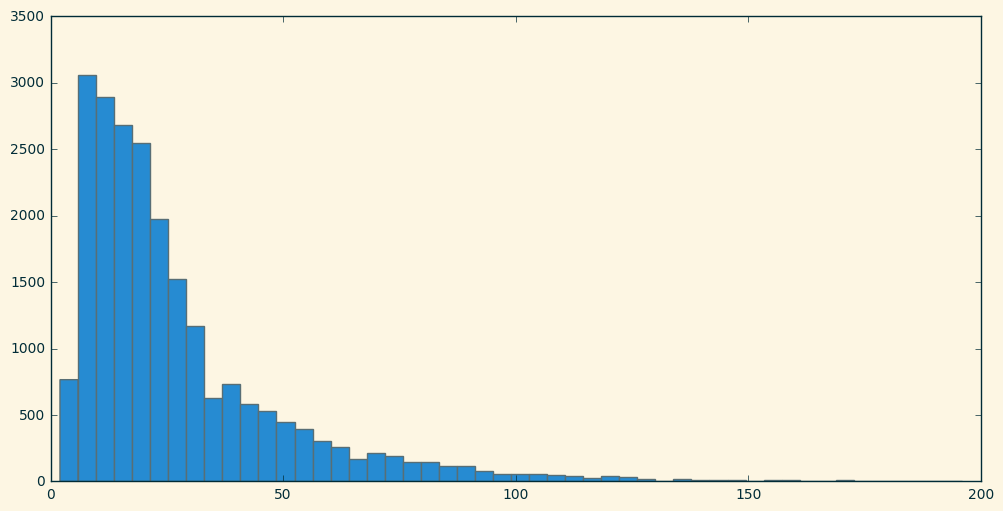

In [74]:
_ = winsorized_obj_counts.hist(bins=50)

# Defining question object categories

In [75]:
q_cat_defs = {
    'vol_cats': ['glass, drinking glass', 'mug', 'bowl', 'bottle', 'box', 'bucket, pail', 'can, tin, tin can', 'container', 'jar'],
    'openable_cats': ['chest of drawers, chest, bureau, dresser', 'cabinet'],
    'surface_cats': ['coffee table, cocktail table', 'bench', 'counter', 'countertop', 'shelf', 'table']
    }

In [76]:
tot_objs = obj_df['objectcounts'].sum()

In [77]:
image_obj_dict = e.to_dict(orient='index')

In [192]:
primary_objs = set(primary_obj_df['shortname'].tolist())

In [79]:
# object_properties.index = object_properties['shortname']
# del object_properties['shortname']

In [80]:
object_properties.index = object_properties['shortname']

In [81]:
obj_prop_lookup = defaultdict(list)
for ob_name, objs in object_properties.to_dict(orient='index').items():
    for prop_type, sel in objs.items():
        if sel:
            obj_prop_lookup[ob_name].append(prop_type)

In [178]:
list(image_obj_dict.keys())[0]

'ADE_train_00000001.jpg'

In [82]:
image_obj_cat_counts = defaultdict(lambda: defaultdict(int))
for img_n, objs in image_obj_dict.items():
    for obj, count in objs.items():
        if not count:
            continue
        elif obj in primary_objs:
            obj_props = obj_prop_lookup[obj]
            for prop in obj_props:
                image_obj_cat_counts[img_n][prop] += count

In [83]:
from math import factorial
def n_choose_2(n):
    if n < 2:
        return 0
    else:
        return factorial(n) / (2 * factorial(n - 2))

In [84]:
len(image_obj_dict)

22210

In [85]:
question_expectations = defaultdict(int)

for img_n, type_counts in image_obj_cat_counts.items():
    if 'metric' in type_counts:
        question_expectations['geometry_metric'] += n_choose_2(type_counts['metric'])
    if 'movable' in type_counts:
        question_expectations['movable'] += type_counts['movable']
    if 'set_on' in type_counts:
        question_expectations['set_on'] += type_counts['set_on']
    if 'container' in type_counts:
        question_expectations['container'] += n_choose_2(type_counts['metric'])
    if 'liquid' in type_counts:
        question_expectations['liquid'] += type_counts['liquid'] 

In [86]:
q_est_df = pd.DataFrame(question_expectations, index=[0]).T
q_est_df.columns = ['raw_estimate']
q_est_df['scaled'] = q_est_df['raw_estimate']

q_est_df['scaled'] = q_est_df['scaled']

q_est_df.filter(like='geo', axis=0)['scaled'] = q_est_df.filter(like='geo', axis=0)['scaled'] * 0.1

q_est_df.ix[q_est_df.index=='geometry_metric', 'scaled'] = q_est_df.ix[q_est_df.index=='geometry_metric', 'scaled'] / 100
q_est_df.ix[q_est_df.index=='container', 'scaled'] = q_est_df.ix[q_est_df.index=='container', 'scaled'] / 100

In [88]:
q_est_df

,raw_estimate,scaled
container,197486.0,1974.86
geometry_metric,384769.0,3847.69
liquid,1200.0,1200.00
movable,44740.0,44740.00
set_on,23351.0,23351.00


# Displaying random image and questions

In [89]:
def get_ade_image(image_df, ade_pre = '.', setting=None, obj_categories=None):
    global img_n
    found = False
    while not found:
        img_row_to_load = np.random.randint(0, image_df.shape[0])
        img_n = img_row_to_load
        image_path = os.path.join(ade_pre, image_df.iloc[img_row_to_load]['folder'], image_df.iloc[img_row_to_load]['filename'])
        mask_path = os.path.join(ade_pre, image_df.iloc[img_row_to_load]['folder'], image_df.iloc[img_row_to_load]['filename'].replace('.jpg', '_seg.png')) 
        img_to_disp = Image.open(image_path)
        mask = Image.open(mask_path)
        if not setting:
            found = 'True'
        elif image_df.iloc[img_row_to_load]['setting'] == setting:
            found = 'True'
        else:
            pass
    return img_to_disp, mask

In [96]:
raw_image, mask_p1 = get_ade_image(image_df, setting='indoor')

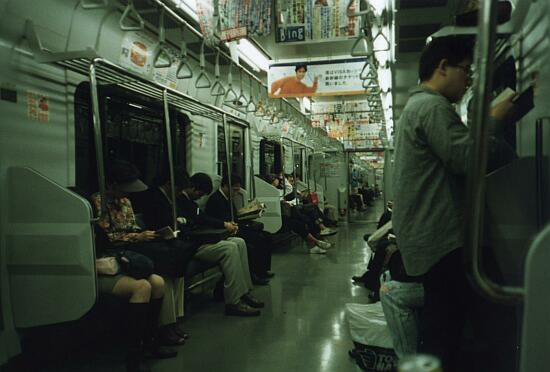

In [97]:
raw_image

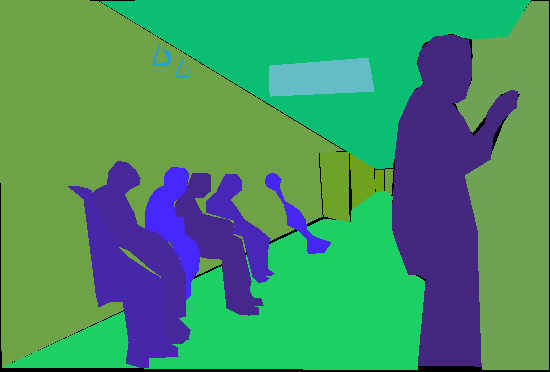

In [98]:
mask_p1

In [80]:
mask_array = np.array(list(mask_p1.getdata()))

In [82]:
test_image_df = img_obj_df.iloc[img_n][img_obj_df.iloc[img_n] != 0]

In [83]:
test_image_df

objectnames
floor, flooring                                        1.0
grandstand, covered stand                              1.0
painting, picture                                      1.0
person, individual, someone, somebody, mortal, soul    1.0
wall                                                   2.0
Name: ADE_train_00004314.jpg, dtype: float32

In [84]:
test_image_objects = img_obj_df.iloc[img_n][img_obj_df.iloc[img_n] != 0].index.tolist()
pruned_test_image_objects = [ob.split(',')[0] for ob in test_image_objects]
object_combos = list(itertools.combinations(pruned_test_image_objects, 2))

for objcts in random.sample(object_combos, 5):
    print('How far is the {} from the {}?'.format(*objcts))

How far is the floor from the wall?
How far is the painting from the person?
How far is the grandstand from the painting?
How far is the person from the wall?
How far is the grandstand from the person?


# Extacting bounding boxes from segmentation mask

In [99]:
test_image_path = '/Users/schwenk/wrk/pqa/ade20k/ADE20K_2016_07_26/images/training/c/computer_room/'
test_image = Image.open(test_image_path + 'ADE_train_00005940.jpg')
test_mask = Image.open(test_image_path + 'ADE_train_00005940_seg.png')
cv_mask = cv2.imread(test_image_path + 'ADE_train_00005940_seg.png')

In [101]:
# Image.fromarray(cv_mask[::,::,::-1])

In [48]:
# pd.value_counts(r_chan.flatten())
# pd.value_counts(g_chan.flatten())
# pd.value_counts(b_chan.flatten())

In [102]:
obj_df['obj_class'] = obj_df.index + 1

In [103]:
split_cols = obj_df[['obj_class', 'objectnames']].to_dict(orient='split')
ob_name_lookup = {pair[0]: pair[1] for pair in split_cols['data']}

# Test Build dataset scaffolding

In [105]:
def extract_objs_bboxes(label_array, image_name):
    obj_mask = label_array[::,::,0:1].reshape(label_array.shape[:2])
    g_chan = label_array[::,::,1:2]
    r_chan = label_array[::,::,2:3]
    class_mask = r_chan.astype(int) / 10 * 256  +  g_chan.astype(int)
    class_mask = class_mask.astype(int)

    detections = defaultdict(dict)
    mask_iter = np.nditer(obj_mask, flags=['multi_index'])
    while not mask_iter.finished:
        pix_val = mask_iter[0].item()
        x_coord, y_coord = mask_iter.multi_index[:2]
        if pix_val not in detections:
            class_assigment = class_mask[x_coord][y_coord].item()
            if class_assigment:
                detections[pix_val]['classID'] = class_assigment
                detections[pix_val]['classDescription'] = ob_name_lookup[detections[pix_val]['classID']]
                detections[pix_val]['rectangle'] = [x_coord, y_coord] * 2
                detections[pix_val]['globalID'] = '_'.join([image_name, str(pix_val)])
        else:
            x_min, y_min, x_max, y_max = detections[pix_val]['rectangle']
            if x_coord > x_min:
                detections[pix_val]['rectangle'][0] = x_coord
            if x_coord < x_max:
                detections[pix_val]['rectangle'][1] = x_coord
            if y_coord > y_min:
                detections[pix_val]['rectangle'][2] = y_coord
            if y_coord < y_max:
                detections[pix_val]['rectangle'][3] = y_coord
        mask_iter.iternext()
    return detections

def build_dataset():
    return

def build_object_entry(image_name, image_path, img_obj_df):
    img_seg_name = image_name.replace('.jpg', '_seg.png')
    pixel_array = cv2.imread(os.path.join(image_path, img_seg_name))
    objects = extract_objs_bboxes(pixel_array, image_name)
    return objects

def build_image_entry(image_df_row, dpp):
    image_fields = {}
    image_name = image_df_row['filename']
    image_path = '../ade20k/' + image_df_row['folder']
    image_fields['imageName'] = image_name
    image_fields['imageName'] = image_name
    image_fields['scene'] = image_df_row['scene']
    image_fields['setting'] = image_df_row['setting']
    image_fields['objects'] = build_object_entry(image_name, image_path, img_obj_df)
    dpp[image_name] = image_fields

def call_apply_fn(df): 
    ds_p = {}
    build_image_entry_part = functools.partial(build_image_entry)
    df.apply((lambda x: build_image_entry_part(x, ds_p)), axis=1)
    return ds_p

In [253]:
# %%time
# n_processes = 8
# pool = Pool(processes=n_processes)

# df = image_df.head(100)
# df_split = np.array_split(df, n_processes)
# pool_results = pool.map(call_apply_fn, df_split)
# combined_results = {}
# for res in pool_results:
#     combined_results.update(res)

In [416]:
image_df.shape[0] / 100 / 60

3.7016666666666667

In [121]:
trr = list(combined_results.values())[40]

In [122]:
trr['imageName']

'ADE_train_00000483.jpg'

In [123]:
trr.keys()

dict_keys(['objects', 'imageName', 'setting', 'scene'])

In [124]:
flat_image_dir = '/Users/schwenk/wrk/pqa/ade20k/ADE20K_2016_07_26/images/training/flattened/'

In [602]:
# 180: {'classDescription': 'stool',
#               'classID': 2586,
#               'globalID': 'ADE_train_00000075.jpg_180',
#               'rectangle': [1088, 1398, 459, 487]}

In [125]:
label_array = cv_mask
obj_mask = label_array[::,::,0:1].reshape(label_array.shape[:2])
g_chan = label_array[::,::,1:2]
r_chan = label_array[::,::,2:3]
class_mask = r_chan.astype(int) / 10 * 256  +  g_chan.astype(int)
class_mask = class_mask.astype(int)

In [126]:
np.unique(obj_mask.flatten())

array([  0,   6,  12,  17,  23,  29,  35,  41,  46,  52,  58,  64,  70,
        75,  81,  87,  93,  99, 104, 110, 116, 122, 128, 133, 139, 145,
       151, 156, 162, 168, 174, 180, 185, 191, 197, 203, 209, 214, 220,
       226, 232, 238, 243, 249, 255], dtype=uint8)

In [127]:
obj1 = obj_mask == 6

In [107]:
test_name = 'ADE_train_00005940.jpg'

In [108]:
cv_mask = cv2.imread(test_image_path + 'ADE_train_00005940_seg.png')

In [216]:
image_df[image_df['filename'] == timg]['scene']

5939    computer_room
Name: scene, dtype: object

In [273]:
primary_objs = set(primary_obj_df['shortname'].tolist())

In [278]:
primary_obj_df['obj_class']  = primary_obj_df.index + 1

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [215]:
obj_df[obj_df['obj_class'] == sample_n]

,objectnames,objectcounts,proportionClassIsPart,wordnet_found,wordnet_level1,wordnet_synset,wordnet_hypernym,wordnet_gloss,wordnet_synonyms,wordnet_frequency,obj_class
2981,"wall socket, wall plug, electric outlet, elect...",1633,0,1,"wall socket, wall plug, electric outlet, elect...","wall socket, wall plug, electric outlet, elect...","[wall socket, wall plug, electric outlet, elec...",receptacle providing a place in a wiring syste...,"wall socket, wall plug, electric outlet, elect...",1,2982


In [283]:
split_cols = primary_obj_df[['obj_class', 'shortname']].to_dict(orient='split')
ob_name_lookup = {pair[0]: pair[1] for pair in split_cols['data']}

In [ ]:
split_cols = obj_df[['obj_class', 'objectnames']].to_dict(orient='split')
ob_name_lookup = {pair[0]: pair[1] for pair in split_cols['data']}

In [129]:
# import pickle
# with open('ob_name_lookup.pkl', 'wb') as f:
#     pickle.dump(ob_name_lookup, f)

# Building selection criteria

In [173]:
# selection_df = img_obj_df.apply(sum, axis=1)
# selection_df[selection_df > 15].shape

In [168]:
list(combined_results.values())[0]

{'imageName': 'ADE_train_00001018.jpg',
 'objects': {8: {'classDescription': 'road',
   'globalID': 'ADE_train_00001018.jpg_8',
   'objectClass': 2131,
   'rectangle': [11, 12, 298, 327],
   'shortName': 'road'},
  16: {'classDescription': 'road',
   'globalID': 'ADE_train_00001018.jpg_16',
   'objectClass': 2131,
   'rectangle': [0, 106, 297, 394],
   'shortName': 'road'},
  40: {'classDescription': 'central reservation',
   'globalID': 'ADE_train_00001018.jpg_40',
   'objectClass': 461,
   'rectangle': [86, 101, 297, 391],
   'shortName': 'central reservation'},
  48: {'classDescription': 'central reservation',
   'globalID': 'ADE_train_00001018.jpg_48',
   'objectClass': 461,
   'rectangle': [126, 15, 297, 192],
   'shortName': 'central reservation'},
  56: {'classDescription': 'truck',
   'globalID': 'ADE_train_00001018.jpg_56',
   'objectClass': 2880,
   'rectangle': [45, 229, 98, 303],
   'shortName': 'truck'},
  64: {'classDescription': 'truck',
   'globalID': 'ADE_train_0000101

In [171]:
scenes_to_try = [
     'kitchen',
 'kitchenette',
    'living_room',
     'bedchamber',
     'bedroom',
]

In [217]:
images_to_sample = defaultdict(int)
for img_n, objs in image_obj_dict.items():
    for obj, count in objs.items():
        if not count:
            continue
        elif obj in short_names.keys() and short_names[obj] in primary_objs:
            images_to_sample[img_n] += count

In [229]:
complex_selected_images = {k: v for k,v in images_to_sample.items() if v > 10 and 'train' in k}
complex_selected_images = set(complex_selected_images.keys())

# Build dataset scaffolding

In [248]:
%%capture
test_sample_df = image_df[image_df['scene'].apply( lambda x: x in scenes_to_try)]
test_sample_df = test_sample_df[image_df['filename'].apply( lambda x: x in complex_selected_images)]

In [250]:
test_sample_df.shape

(1552, 4)

In [252]:
# %%time
# n_processes = 8
# pool = Pool(processes=n_processes)

# df_split = np.array_split(test_sample_df, n_processes)
# pool_results = pool.map(ade_ext.call_apply_fn, df_split)
# combined_results = {}
# for res in pool_results:
#     combined_results.update(res)

In [257]:
# with open('store_indoor_sample_results.pkl', 'wb') as f:
#     pickle.dump(combined_results, f)

In [10]:
object_properties = pd.read_csv('../ade20k/object_annotations.csv')

label_assignments = defaultdict(set)
for label_type in object_properties.iloc[:, 1:].columns.tolist():
    label_assignments[label_type].update(object_properties[object_properties[label_type] == 1]['shortname'].tolist())

In [168]:
labels_cols = object_properties.iloc[:, 1:]

What is the farthest object from the painting?


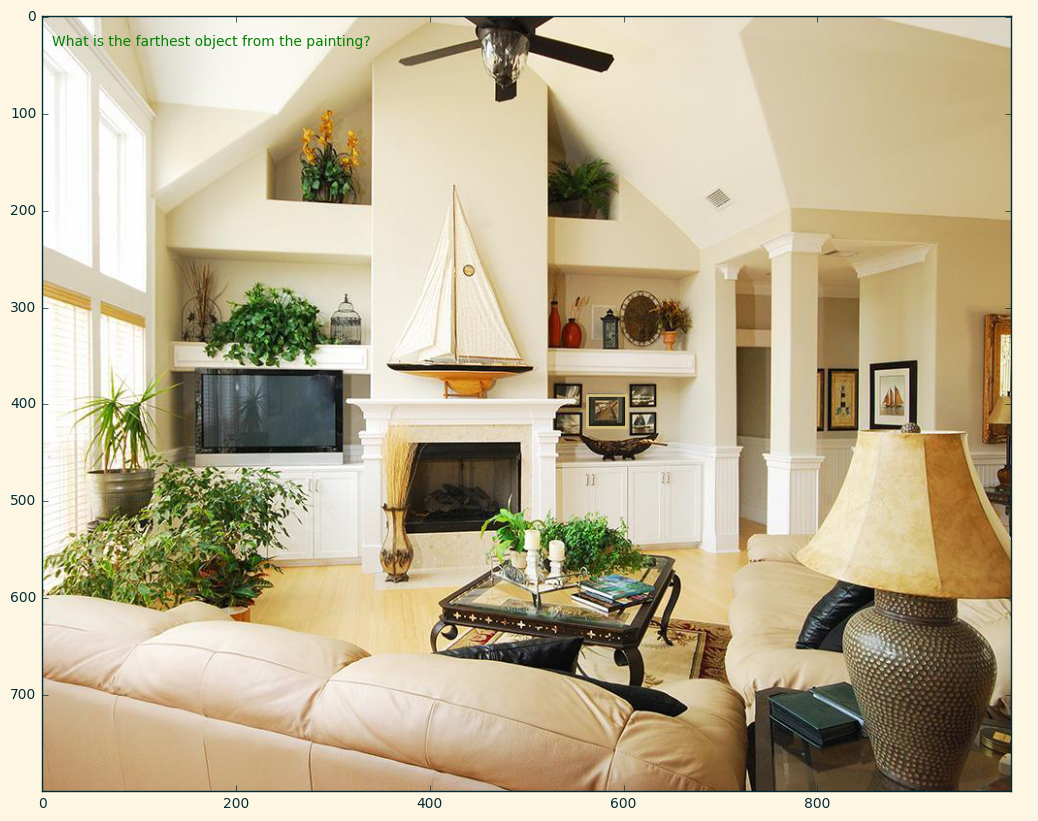

In [220]:
# img_index = random.randint(0, len(combined_results))
# example_image_anno = list(combined_results.values())[img_index]
# image_questions = ade_ext.generate_questions_for_image(example_image_anno, label_assignments)
# random_question = np.random.choice(list(image_questions.values()), 1).item()
# ade_ext.draw_question(example_image_anno, random_question['gids'], random_question['question_text'])
# print(random_question['question_text'])

# Explore synthetic questions

How much liquid could the glass hold?


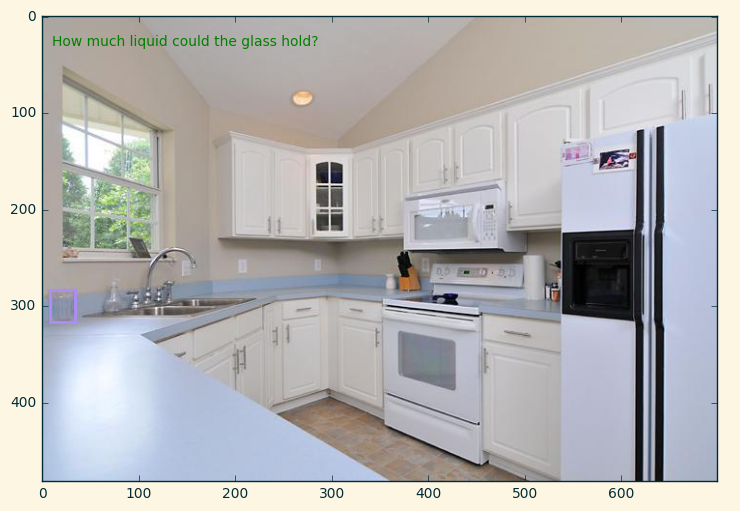

In [258]:
img_index = random.randint(0, len(combined_results))
example_image_anno = list(combined_results.values())[img_index]
image_questions = ade_ext.generate_questions_for_image(example_image_anno, label_assignments)
random_question = np.random.choice(list(image_questions.values()), 1).item()
ade_ext.draw_question(example_image_anno, random_question['gids'], random_question['question_text'])
print(random_question['question_text'])

## observations

Need to make every question multiple choice

for some categories, answer options don't have to be in the same property class

need to change templates somewhat to reflect directions vs questions

filter on image complexity, scene type

# Generate Sample HTML

In [260]:
from pqa_utils.ade_extractor import filter_image

In [277]:
import jinja2

In [262]:
with open('store_indoor_sample_results.pkl', 'rb') as f:
    indoor_sample_images = pickle.load(f)

In [269]:
filtered_sample = {k:v for k,v in indoor_sample_images.items() if filter_image(testi)}

In [273]:
testi = list(filtered_sample.values())[0]

./test_ds_indoor_sample/images/ADE_train_00003583.png


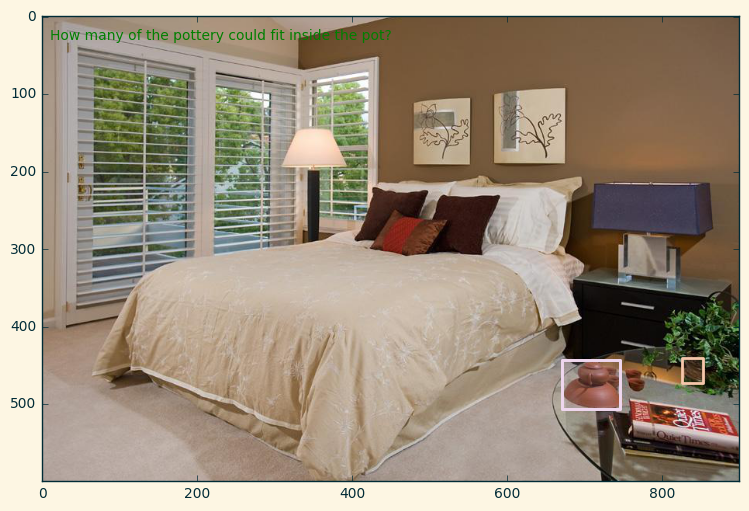

In [433]:
img_index = random.randint(0, len(filtered_sample))
example_image_anno = list(filtered_sample.values())[img_index]
image_questions = ade_ext.generate_questions_for_image(example_image_anno, label_assignments)
random_question = np.random.choice(list(image_questions.values()), 1).item()
drawn_on_image = ade_ext.draw_question(example_image_anno, random_question['gids'], random_question['question_text'])
image_path = image_out_path + example_image_anno['imageName'].replace('.jpg', '.png')
plt.savefig(image_path, transparent=True)

In [278]:
j2env = jinja2.Environment()

In [326]:
# page_html = """
# <!DOCTYPE html>
# <html>
#   <head>
#     <style type="text/css">
#        .container {
#           }
#     </style>
#   </head>
#   <body style=max-width: 100px>
#     <div class="container">
#       <h1>Question Type: {{lesson}}</h1>
#       <ul>
#         {% for topic in topics %}
#         <p>
#         </p>
#         <p>{{topic}}</p>
#         {% endfor %}
#       </ul>
#     </div>
#     <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
#     <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
#   </body>
# </html>
# """

In [406]:
page_html = """
<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        <p>
        <p>{{image_path}}</p>
        </p>
        <p>{{question_text}}</p>
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>
"""

In [442]:
image_path

'./test_ds_indoor_sample/images/ADE_train_00003583.png'

In [ ]:
ima

In [479]:
def make_question_data(being_asked, image_path):
    nested_text = {}
    image_rel_path = '../' + '/'.join(image_path.split('/')[2:])
    image_link = '<img src="' + image_rel_path + '" width=500px>'
    nested_text['image_path'] = image_link
    nested_text['question_text'] = being_asked['question_text']
    return nested_text

In [480]:
html_out_path = './test_ds_indoor_sample/gen_html/'
image_out_path = './test_ds_indoor_sample/images/'

In [481]:
question_data

{'image_path': '<img src="../images/images/ADE_train_00003583.png" width=500px>',
 'question_text': 'How many of the pottery could fit inside the pot?'}

In [482]:
question_data = make_question_data(random_question, image_path)
def make_page_html(question_data, page_html):
    return j2env.from_string(page_html).render(image_path=question_data['image_path'], question_text=question_data['question_text'])

In [483]:
test_html = make_page_html(question_data, page_html)

In [484]:
print(test_html)


<!DOCTYPE html>
<html>
  <head>
    <style type="text/css">
       .container {
          }
    </style>
  </head>
  <body style=max-width: 100px>
    <div class="container">
      <ul>
        <p>
        <p><img src="../images/ADE_train_00003583.png" width=500px></p>
        </p>
        <p>How many of the pottery could fit inside the pot?</p>
      </ul>
    </div>
    <script src="http://code.jquery.com/jquery-1.10.2.min.js"></script>
    <script src="http://netdna.bootstrapcdn.com/bootstrap/3.0.0/js/bootstrap.min.js"></script>
  </body>
</html>


In [485]:
html_out_file = os.path.join(html_out_path, 'test' + '.html')
with open(html_out_file, 'w') as f:
    f.write(test_html.encode('ascii', 'ignore').decode('utf-8'))

In [487]:
# HTML(test_html)

# hide

In [222]:
import json
example_image_anno['objects'] = {'local_id' + str(k): v for k,v in example_image_anno['objects'].items()}

temp_dict = {}
for iv, obv in example_image_anno['objects'].items():
        obv['objectClass'] = str(obv['objectClass'])
        obv['rectangle'] = str(obv['rectangle'])

In [224]:
example_image_anno['questions'] = image_questions

In [225]:
with open('example.json', 'w') as f:
    json.dump(example_image_anno, f, indent = 3)

In [226]:
dynamics_templates = {
    '1_moves_how': 'If the force shown is applied to the {}, how will it move?',
    '1_moves_where': 'If the force shown is applied to the {}, where will it end up?',
    '1_apply_to_move': 'If we want the {} to end up in the region shown, how should we apply a force?'
}

statics_templates = {
    '2_hypo_removal': '',
    '1_apply_to_tip': '',
    '1_apply_to_fall': ''
}

metrics_templates = {
    '2_dist_between': 'How far is the {} from the {}?',
    '1_farthest_from': 'What is the farthest object from the {}?',
    '1_closest_to': 'What is the closest object to the {}?',
    '3_maximize_seperation': 'Where should the {} be moved such that is equally far from the {} and the {}'
}

volume_templates ={
    '2_can_fit': 'Can the {} fit inside the {}?',
    '1_largest_fit': 'What is the largest object in the scene that will fit inside the {}?',
    '2_how_many_fit': 'How many of the {} could fit inside the {}?'
}

liquid_templates = {
    '2_can_liquid_fit': 'Can the {} hold the liquid contained in the {}?',
    '1_est_volums': 'How much liquid could the {} hold?',
}

In [ ]:
# scene_image = Image.open(flat_image_dir + test_image_name)

plt.imshow(scene_image)
ax = plt.gca()
ax.set_aspect('equal')
ade_ext.draw_obj_sample(ax, test_objs)

In [ ]:
obj_cat = r_chan.tolist()
build_val_list = [item for sublist in obj_cat for item in sublist]

In [256]:
%%time
dpp = {}
ade_ext.build_image_entry(image_df[image_df['filename'] == test_image_name].iloc[0], dpp, ob_name_lookup)

CPU times: user 666 ms, sys: 25.8 ms, total: 692 ms
Wall time: 679 ms


In [ ]:
# pd.Series([sc.split('/')[-1] for sc in ade_index.scene.tolist() if sc.split('/')[0] != sc.split('/')[-1]]).value_counts()

In [ ]:
# for qt, cats in q_cat_defs.items():
#     obj_count = obj_df[obj_df['objectnames'].isin(cats)].sum()[1]
#     print(qt, int(obj_count))